In [149]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn import linear_model, metrics

ITERS=100000

df = pd.read_csv("data/HW4/heart.csv")
df.head()

X = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:, [-1]])

np.random.seed(123)
idx = np.random.choice(303, 303, replace=False)
tr_idx, te_idx = idx[:200], idx[200:]

X_tr_raw, y_tr_raw = X[tr_idx], y[tr_idx]
X_te_raw, y_te_raw = X[te_idx], y[te_idx]


def normalize(mode, X_tr, X_te):
  if mode == "z":
    # z-score normalize
    X_tr_mu = np.mean(X_tr, axis=0, keepdims=True)
    X_tr_sig = np.std(X_tr, axis=0, keepdims=True)

    X_tr_ = (X_tr - X_tr_mu) / X_tr_sig
    X_te_ = (X_te - X_tr_mu) / X_tr_sig
    return X_tr_, X_te_
  elif mode == "min-max":
    # min-max 0-1 normalization
    X_tr_mi = np.min(X_tr, axis=0, keepdims=True)
    X_tr_ma = np.max(X_tr, axis=0, keepdims=True)
    X_tr_ = (X_tr - X_tr_mi) / (X_tr_ma - X_tr_mi)
    X_te_ = (X_te - X_tr_mi) / (X_tr_ma - X_tr_mi)
    return X_tr_, X_te_
  else:
    return X_tr, X_te


def logit(w, b, X):
  return X @ w + b


def logit_nob(w, X):
  return X @ w


def prob(w, b, X, y):
  logits = logit(w, b, X)
  assert(y.shape == logits.shape)
  return 1 / (1 + np.exp(-y * logits))


def prob_nob(w, X, y):
  logits = logit_nob(w, X)
  assert(y.shape == logits.shape)
  return 1 / (1 + np.exp(-y * logits))


def loss(w, b, X, y):
  logits = logit(w, b, X)
  assert(y.shape == logits.shape)
  return np.mean(np.log(1 + np.exp(-y * logits)))


def loss_nob(w, X, y):
  logits = logit_nob(w, X)
  assert(y.shape == logits.shape)
  return np.mean(np.log(1 + np.exp(-y * logits)))


def test_err(reg: linear_model.LogisticRegression, X, y):
  y_hat = reg.predict(X)
  err = np.not_equal(y_hat, y.flatten())
  return np.sum(err)


def reg_loss(reg: linear_model.LogisticRegression, X, y):
  w, b = reg.coef_.reshape((-1, 1)), reg.intercept_
  wx_b = reg.decision_function(X).reshape((-1, 1))
  assert(np.allclose(wx_b, logit(w, b, X)))
  return loss(w, b, X, y)


def experiment(mode, X_tr, X_te, y_tr, y_te):
  print(f"=== Using {mode} Normalization ===")
  X_tr_, X_te_ = normalize(mode, X_tr, X_te)
  reg = linear_model.LogisticRegression(C=999999999).fit(X_tr_, y_tr.flatten())
  w, b = reg.coef_.reshape((-1, 1)), reg.intercept_

  print("\tw: ", np.round(w, 4).flatten())
  print("\tb: ", np.round(b, 4))

  # print(f"=== Testing ===")
  # err = test_err(reg, X_te_, y_te)
  # print(f"\tError Rate: {np.sum(err)}/{len(y_te)}={np.sum(err)/len(y_te):0.4f}")
  y_1s_tr = np.where(y_tr == 0, -1, 1)
  y_1s_te = np.where(y_te == 0, -1, 1)

  tr_loss = reg_loss(reg, X_tr_, y_1s_tr)
  te_loss = reg_loss(reg, X_te_, y_1s_te)
  print(f"\tTrain Loss: {tr_loss}, Test Loss: {te_loss}")


  # print(y_tr[:10], y_1s_tr[:10])
  # y_hat = prob(w, b, X_tr_, y_1s_tr)
  # y_hat2 = reg.predict_proba(X_tr_)
  # print(y_hat[:10], y_hat2[:10])
  # calc_loss = metrics.log_loss(y_tr, y_hat2[:,1].flatten())
  # print(f"\tCalculated Loss: {calc_loss}")
  print()
  print("-" * 50)
  print()
  return tr_loss, te_loss


In [150]:
tr_loss, te_loss = experiment(
    "min-max", X_tr_raw, X_te_raw, y_tr_raw, y_te_raw)

=== Using min-max Normalization ===
	w:  [-0.0916 -2.3859  2.5735 -3.329  -3.3522  0.5152  0.6446  4.345  -0.9711
 -4.1391  1.8231 -3.505  -2.4696]
	b:  [2.4201]
	Train Loss: 0.3138296347754303, Test Loss: 0.44660770010026035

--------------------------------------------------



In [154]:
import tqdm


def compute_gradient(w, X, y):
  prob_correct = prob_nob(w, X, y)
  prob_wrong = 1 - prob_correct
  assert(y.shape == prob_wrong.shape)
  matrix = y * X * prob_wrong
  return -np.mean(matrix, axis=0).reshape((-1, 1))


def experiment_coordinate(mode, thresh, lr, X_tr, y_tr, X_te, y_te, sel_coord="mag", iters=10000):
  print(
      f"*** Using {mode} Normalization, thresh {thresh:0.5f}, Coordinate Selector mode {sel_coord}")
  np.random.seed(123)
  X_tr_, X_te_ = normalize(mode, X_tr, X_te)
  n_tr, n_te = X_tr_.shape[0], X_te_.shape[0]

  # add bias to data
  X_tr_, X_te_ = np.hstack(
      (X_tr_, np.ones((n_tr, 1)))
  ), np.hstack((X_te_, np.ones((n_te, 1))))

  w = np.random.normal(size=(X_tr_.shape[1], 1))
  losses = [loss_nob(w, X_tr_, y_tr)]
  te_losses = [loss_nob(w, X_te_, y_te)]

  for i in range(iters):
    gradient = compute_gradient(w, X_tr_, y_tr)
    gradient_norm = np.linalg.norm(gradient.flatten())
    if gradient_norm <= thresh:
      # print(f"Breaking on iteration [{i}]")
      break

    if sel_coord == "mag":
      idx_big = np.argmax(np.abs(gradient).flatten())
    elif sel_coord == "random":
      idx_big = np.random.randint(0, len(w), size=1).item()

    sign = np.sign(gradient[idx_big, 0])
    w[idx_big, 0] -= lr * sign * gradient_norm
    losses.append(loss_nob(w, X_tr_, y_tr))
    te_losses.append(loss_nob(w, X_te_, y_te))
  print("-" * 50)

  return w, losses, te_losses, X_tr_, X_te_


In [155]:
import matplotlib.pyplot as plt

def batch_experiment(thresh=1e-1, lr=1e-3, iters=10000):
  _, losses_mag, te_losses_mag, _, _ = experiment_coordinate(
      "min-max", thresh, lr, X_tr_raw, y_tr_raw, X_te_raw, y_te_raw, sel_coord="mag", iters=iters
  )
  _, losses_rdm, te_losses_rdm, _, _ = experiment_coordinate(
      "min-max", thresh, lr, X_tr_raw, y_tr_raw, X_te_raw, y_te_raw, sel_coord="random", iters=iters
  )

  ct = max(len(losses_mag), len(losses_rdm))
  x_ax = np.arange(0, ct)
  line = np.ones_like(x_ax)
  plt.plot(range(len(losses_mag)), losses_mag, "bo-", markevery=1000, label="Coordinate Descent (mine) (tr)")
  # plt.plot(x_ax, te_losses_mag, "co-", markevery=1000, label="Coordinate Descent (mine) (te)")
  plt.plot(x_ax, line * tr_loss, "r-", label="sklearn (train)")
  # plt.plot(x_ax, line * te_loss, "y-", label="sklearn (test)")
  plt.plot(range(len(losses_rdm)), losses_rdm, "go-", label="Coordinate Descent (random) (tr)", markevery=1000)
  # plt.plot(x_ax, te_losses_rdm, "mo-", label="Coordinate Descent (random) (te)", markevery=1000)
  plt.legend()
  plt.title(f"Loss Plots ($\lambda$={lr},thresh={thresh}). $L(w) = \\frac{{1}}{{n}}\sum_{{i=1}}^n \\ln(1 + exp(-y^{{(i)}}(w \cdot x^{{(i)}}))$)");
  plt.show()

*** Using min-max Normalization, thresh 0.00100, Coordinate Selector mode mag
--------------------------------------------------
*** Using min-max Normalization, thresh 0.00100, Coordinate Selector mode random
--------------------------------------------------


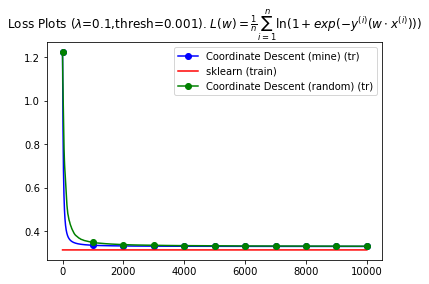

*** Using min-max Normalization, thresh 0.00100, Coordinate Selector mode mag
--------------------------------------------------
*** Using min-max Normalization, thresh 0.00100, Coordinate Selector mode random
--------------------------------------------------


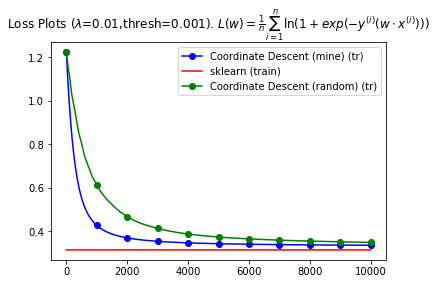

*** Using min-max Normalization, thresh 0.00100, Coordinate Selector mode mag
--------------------------------------------------
*** Using min-max Normalization, thresh 0.00100, Coordinate Selector mode random
--------------------------------------------------


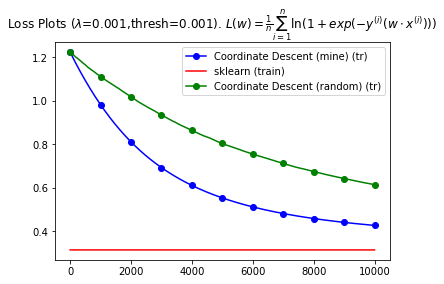

*** Using min-max Normalization, thresh 0.00100, Coordinate Selector mode mag
--------------------------------------------------
*** Using min-max Normalization, thresh 0.00100, Coordinate Selector mode random
--------------------------------------------------


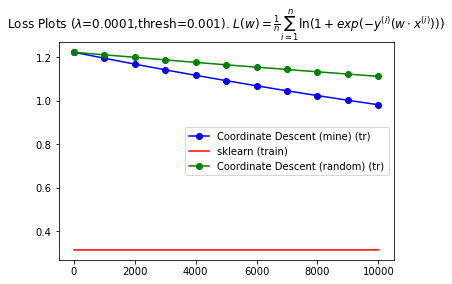

*** Using min-max Normalization, thresh 0.00100, Coordinate Selector mode mag
--------------------------------------------------
*** Using min-max Normalization, thresh 0.00100, Coordinate Selector mode random
--------------------------------------------------


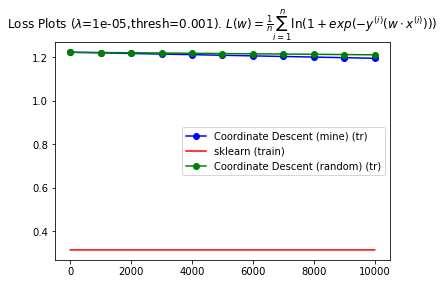

In [156]:
batch_experiment(thresh=1e-3,lr=1e-1)
batch_experiment(thresh=1e-3,lr=1e-2)
batch_experiment(thresh=1e-3,lr=1e-3)
batch_experiment(thresh=1e-3,lr=1e-4)
batch_experiment(thresh=1e-3,lr=1e-5)